In [1]:
!pip install tables
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import bz2
from glob import glob
def restore_df(path):
    with pd.HDFStore(path, mode = 'r') as store:
        df = store.get('game')
        df.attrs = store.get_storer('game').attrs.my_attribute
        return df

     |████████████████████████████████| 5.9 MB 4.3 MB/s            


In [2]:
italy_wales = restore_df("../input/socceranalytics/velocities/velocities/italyvwales.h5.h5")

In [3]:
players = []
for player_id, player_name in italy_wales.attrs['player_map'].items():
    players.append(player_name)

In [4]:
df = pd.read_csv('../input/fifa-player-stats-database/FIFA21_official_data.csv')
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness
0,176580,L. Suárez,33,https://cdn.sofifa.com/players/176/580/20_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,87,87,Atlético Madrid,https://cdn.sofifa.com/teams/240/light_30.png,...,38.0,27.0,25.0,31.0,33.0,37.0,ST,87.0,€64.6M,57.0
1,192985,K. De Bruyne,29,https://cdn.sofifa.com/players/192/985/20_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,91,91,Manchester City,https://cdn.sofifa.com/teams/10/light_30.png,...,53.0,15.0,13.0,5.0,10.0,13.0,CAM,91.0,€161M,68.0
2,212198,Bruno Fernandes,25,https://cdn.sofifa.com/players/212/198/20_60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,87,90,Manchester United,https://cdn.sofifa.com/teams/11/light_30.png,...,55.0,12.0,14.0,15.0,8.0,14.0,CAM,88.0,€124.4M,72.0
3,194765,A. Griezmann,29,https://cdn.sofifa.com/players/194/765/20_60.png,France,https://cdn.sofifa.com/flags/fr.png,87,87,FC Barcelona,https://cdn.sofifa.com/teams/241/light_30.png,...,49.0,14.0,8.0,14.0,13.0,14.0,ST,87.0,€103.5M,59.0
4,224334,M. Acuña,28,https://cdn.sofifa.com/players/224/334/20_60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,83,83,Sevilla FC,https://cdn.sofifa.com/teams/481/light_30.png,...,79.0,8.0,14.0,13.0,13.0,14.0,LB,83.0,€46.2M,79.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17108 entries, 0 to 17107
Data columns (total 65 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        17108 non-null  int64  
 1   Name                      17108 non-null  object 
 2   Age                       17108 non-null  int64  
 3   Photo                     17108 non-null  object 
 4   Nationality               17108 non-null  object 
 5   Flag                      17108 non-null  object 
 6   Overall                   17108 non-null  int64  
 7   Potential                 17108 non-null  int64  
 8   Club                      16783 non-null  object 
 9   Club Logo                 17108 non-null  object 
 10  Value                     17108 non-null  object 
 11  Wage                      17108 non-null  object 
 12  Special                   17108 non-null  int64  
 13  Preferred Foot            17108 non-null  object 
 14  Intern

In [6]:
to_drop = ["Special", "Club Logo", "Flag", "Photo", "Real Face", "Skill Moves"]
df = df.drop(to_drop, axis= 1)

In [7]:
 def leven(x, y):
    """
    String Levenshtein distance (edit distance)
    From https://devrescue.com/levenshtein-distance-in-python/
    """
    n = len(x)
    m = len(y)
    
    x_l = x.lower()
    y_l = y.lower()

    A = [[i + j for j in range(m + 1)] for i in range(n + 1)]

    for i in range(n):
        for j in range(m):
            A[i + 1][j + 1] = min(A[i][j + 1] + 1,              # insert
                                  A[i + 1][j] + 1,              # delete
                                  A[i][j] + int(x_l[i] != y_l[j]))  # replace

    return A[n][m] / max(len(x), len(y))

In [8]:
last_names = [player.split(" ")[-1] for player in players]

In [9]:
df['possible_match'] = df.Name.apply(lambda x: x.split(" ")[-1] in last_names)

In [10]:
df_matches = df[df['possible_match'] == True]

In [11]:
distances = dict()
for player in players:
    distances[player] = []
    initials = player.split(" ")[0][0] + " " + player.split(" ")[-1]
    for entry in df_matches.Name.to_numpy():
        distances[player].append((leven(initials.strip(), entry.strip()), entry))

In [12]:
fifa_map = dict()
fifa_names = []
for key, poss in distances.items():
    name = sorted(poss, key=lambda x: x[0])[0][1]
    fifa_names.append(name)
    fifa_map[key] = name

In [13]:
len(players)

52

In [14]:
len(fifa_names)

52

In [15]:
#some players are double because same name
our_players = df[df.Name.isin(fifa_names) & (df.Nationality.isin(["Italy", "Wales"]))].sort_values(by = "Name")
#our_players = df[df.Name.isin(fifa_names)].sort_values(by = "Name")

In [16]:
df.Value.iloc[0][1:][:-1]

'31.5'

In [17]:
def money_convert(x):
    x = x[1:]
    mult = x[-1]
    x = x[:-1]
    x = float(x)
    if mult == "K":
        x = x*1e3
    if mult == "M":
        x = x*1e6
    return x

In [18]:
#one player missing
our_players

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,...,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness,possible_match
6534,173752,20 C. Gunter,29,Wales,67,67,Reading,€625K,€7K,Right,...,12.0,8.0,16.0,16.0,9.0,RB,67.0,€1.2M,68.0,True
9246,237383,A. Bastoni,21,Italy,75,83,Inter,€9M,€46K,Left,...,11.0,5.0,9.0,11.0,12.0,CB,77.0,€16.7M,78.0,True
1444,208596,A. Belotti,26,Italy,80,83,Torino,€18.5M,€57K,Right,...,13.0,7.0,12.0,14.0,7.0,ST,83.0,€32.8M,55.0,True
16359,200715,A. Davies,27,Wales,70,73,Stoke City,€1.6M,€12K,Right,...,70.0,68.0,67.0,68.0,71.0,GK,70.0,€3.2M,18.0,True
19,203551,A. Florenzi,29,Italy,81,81,Paris Saint-Germain,€14.5M,€84K,Right,...,9.0,8.0,10.0,11.0,10.0,RB,81.0,€26.8M,75.0,True
15733,225116,A. Meret,23,Italy,78,87,Napoli,€12.5M,€36K,Left,...,79.0,74.0,70.0,77.0,82.0,GK,78.0,€23.8M,10.0,True
174,186561,A. Ramsey,29,Wales,82,82,Juventus,€21.5M,€98K,Right,...,6.0,11.0,5.0,10.0,8.0,CM,82.0,€35.5M,68.0,True
14854,248687,B. Cabango,20,Wales,62,78,Swansea City,€625K,€3K,Right,...,8.0,11.0,7.0,9.0,9.0,CB,64.0,€1.6M,60.0,True
890,208268,B. Cristante,25,Italy,78,82,Roma,€12M,€500,Right,...,3.0,5.0,3.0,3.0,5.0,CDM,79.0,€26.1M,74.0,True
803,205923,B. Davies,27,Wales,80,81,Tottenham Hotspur,€14.5M,€86K,Left,...,11.0,7.0,6.0,7.0,14.0,LB,80.0,€28.6M,77.0,True


In [19]:
our_players['Value'] = our_players['Value'].apply(money_convert)
our_players['Wage'] = our_players['Wage'].apply(money_convert)
italy_fifa = our_players[our_players.Nationality == "Italy"]
wales_fifa = our_players[our_players.Nationality == "Wales"]

In [20]:
our_players.groupby('Nationality').mean()[['Value', 'Wage', 'Overall']]

,Value,Wage,Overall
Nationality,,,
Italy,1.872000e+07,63004.000000,79.880000
Wales,5.194231e+06,28653.846154,70.961538


In [21]:
italy_fifa['Overall'].describe()

count    25.000000
mean     79.880000
std       5.190697
min      64.000000
25%      78.000000
50%      80.000000
75%      84.000000
max      87.000000
Name: Overall, dtype: float64

In [22]:
wales_fifa['Overall'].describe()

count    26.000000
mean     70.961538
std       5.730485
min      62.000000
25%      67.000000
50%      70.000000
75%      74.750000
max      83.000000
Name: Overall, dtype: float64

In [23]:
italy_fifa['Preferred Foot'].value_counts()

Right    17
Left      8
Name: Preferred Foot, dtype: int64

In [24]:
wales_fifa['Preferred Foot'].value_counts()

Right    21
Left      5
Name: Preferred Foot, dtype: int64

In [25]:
italy_fifa['Value'].describe()

count    2.500000e+01
mean     1.872000e+07
std      1.265082e+07
min      1.000000e+06
25%      1.200000e+07
50%      1.550000e+07
75%      1.850000e+07
max      5.000000e+07
Name: Value, dtype: float64

In [26]:
wales_fifa['Value'].describe()

count    2.600000e+01
mean     5.194231e+06
std      6.628889e+06
min      5.750000e+05
25%      1.100000e+06
50%      2.050000e+06
75%      5.275000e+06
max      2.450000e+07
Name: Value, dtype: float64

In [27]:
our_players.to_csv("our_players.csv", index = False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


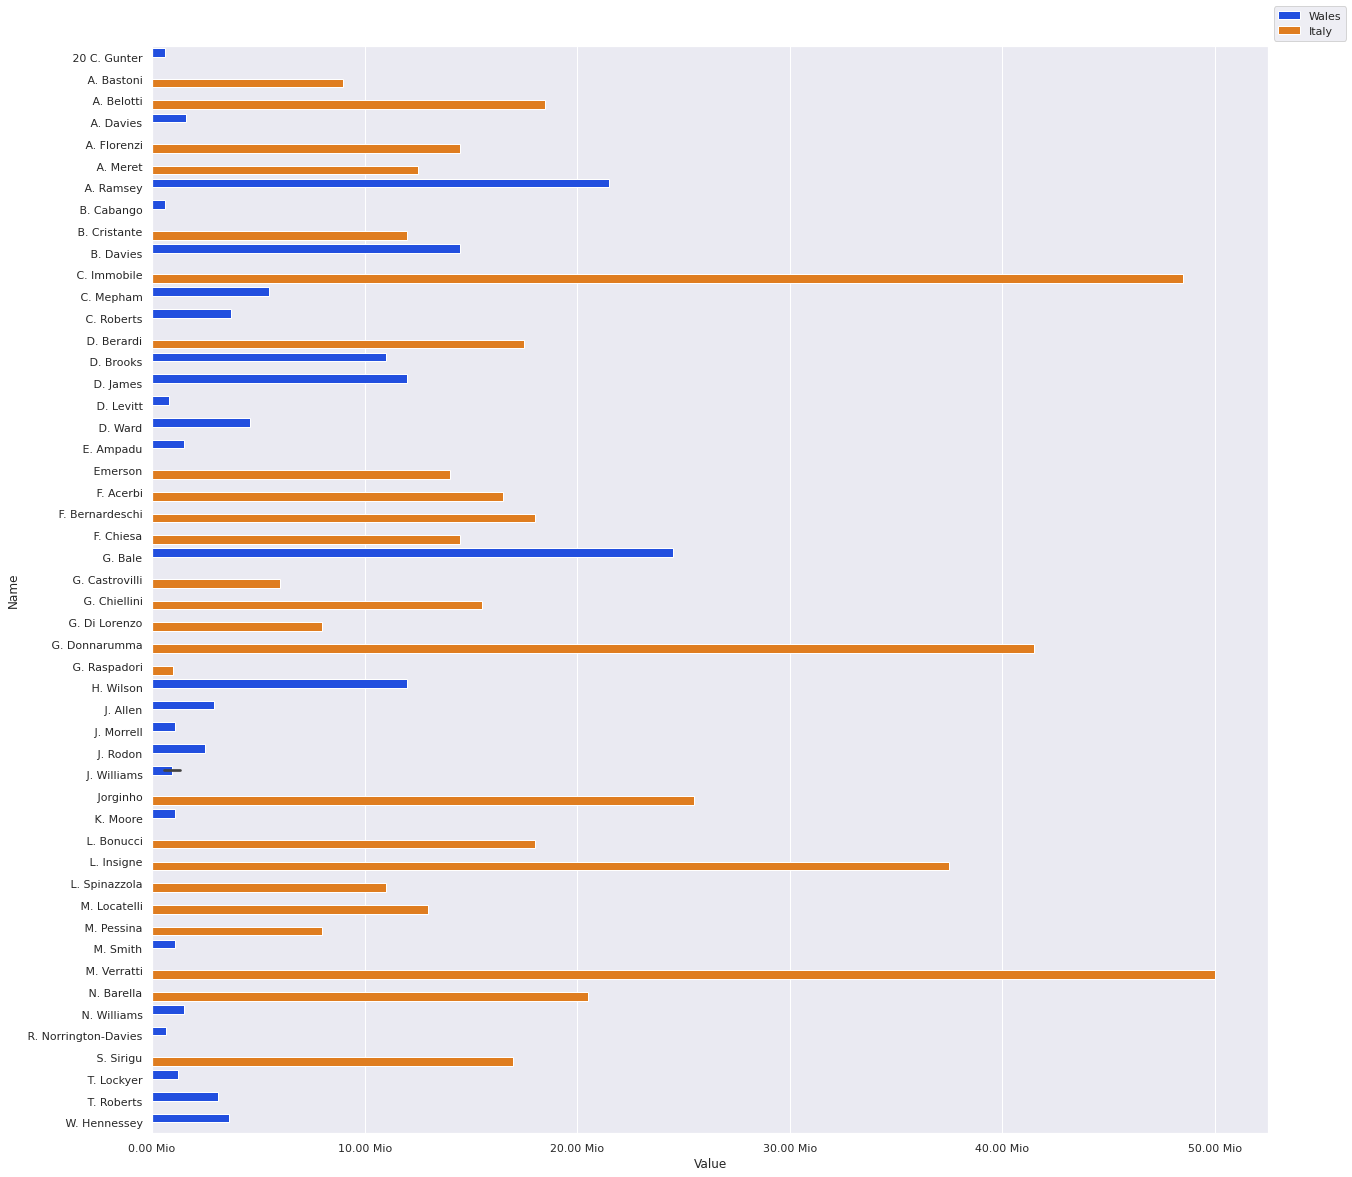

In [28]:
sns.set(style="darkgrid")    
sns.set(rc={'figure.figsize':(20,20)}) 
palette = sns.color_palette("bright", 4)
g = sns.barplot(x="Value", y = "Name", hue="Nationality", data=our_players, palette= palette, orient="h")
g.legend(bbox_to_anchor=(1, 1), ncol=1)
xlabels = ['{:,.2f}'.format(x) + ' Mio' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig("player_values.png")
plt.show()

In [29]:
our_players

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,...,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness,possible_match
6534,173752,20 C. Gunter,29,Wales,67,67,Reading,625000.0,7000.0,Right,...,12.0,8.0,16.0,16.0,9.0,RB,67.0,€1.2M,68.0,True
9246,237383,A. Bastoni,21,Italy,75,83,Inter,9000000.0,46000.0,Left,...,11.0,5.0,9.0,11.0,12.0,CB,77.0,€16.7M,78.0,True
1444,208596,A. Belotti,26,Italy,80,83,Torino,18500000.0,57000.0,Right,...,13.0,7.0,12.0,14.0,7.0,ST,83.0,€32.8M,55.0,True
16359,200715,A. Davies,27,Wales,70,73,Stoke City,1600000.0,12000.0,Right,...,70.0,68.0,67.0,68.0,71.0,GK,70.0,€3.2M,18.0,True
19,203551,A. Florenzi,29,Italy,81,81,Paris Saint-Germain,14500000.0,84000.0,Right,...,9.0,8.0,10.0,11.0,10.0,RB,81.0,€26.8M,75.0,True
15733,225116,A. Meret,23,Italy,78,87,Napoli,12500000.0,36000.0,Left,...,79.0,74.0,70.0,77.0,82.0,GK,78.0,€23.8M,10.0,True
174,186561,A. Ramsey,29,Wales,82,82,Juventus,21500000.0,98000.0,Right,...,6.0,11.0,5.0,10.0,8.0,CM,82.0,€35.5M,68.0,True
14854,248687,B. Cabango,20,Wales,62,78,Swansea City,625000.0,3000.0,Right,...,8.0,11.0,7.0,9.0,9.0,CB,64.0,€1.6M,60.0,True
890,208268,B. Cristante,25,Italy,78,82,Roma,12000000.0,50.0,Right,...,3.0,5.0,3.0,3.0,5.0,CDM,79.0,€26.1M,74.0,True
803,205923,B. Davies,27,Wales,80,81,Tottenham Hotspur,14500000.0,86000.0,Left,...,11.0,7.0,6.0,7.0,14.0,LB,80.0,€28.6M,77.0,True


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


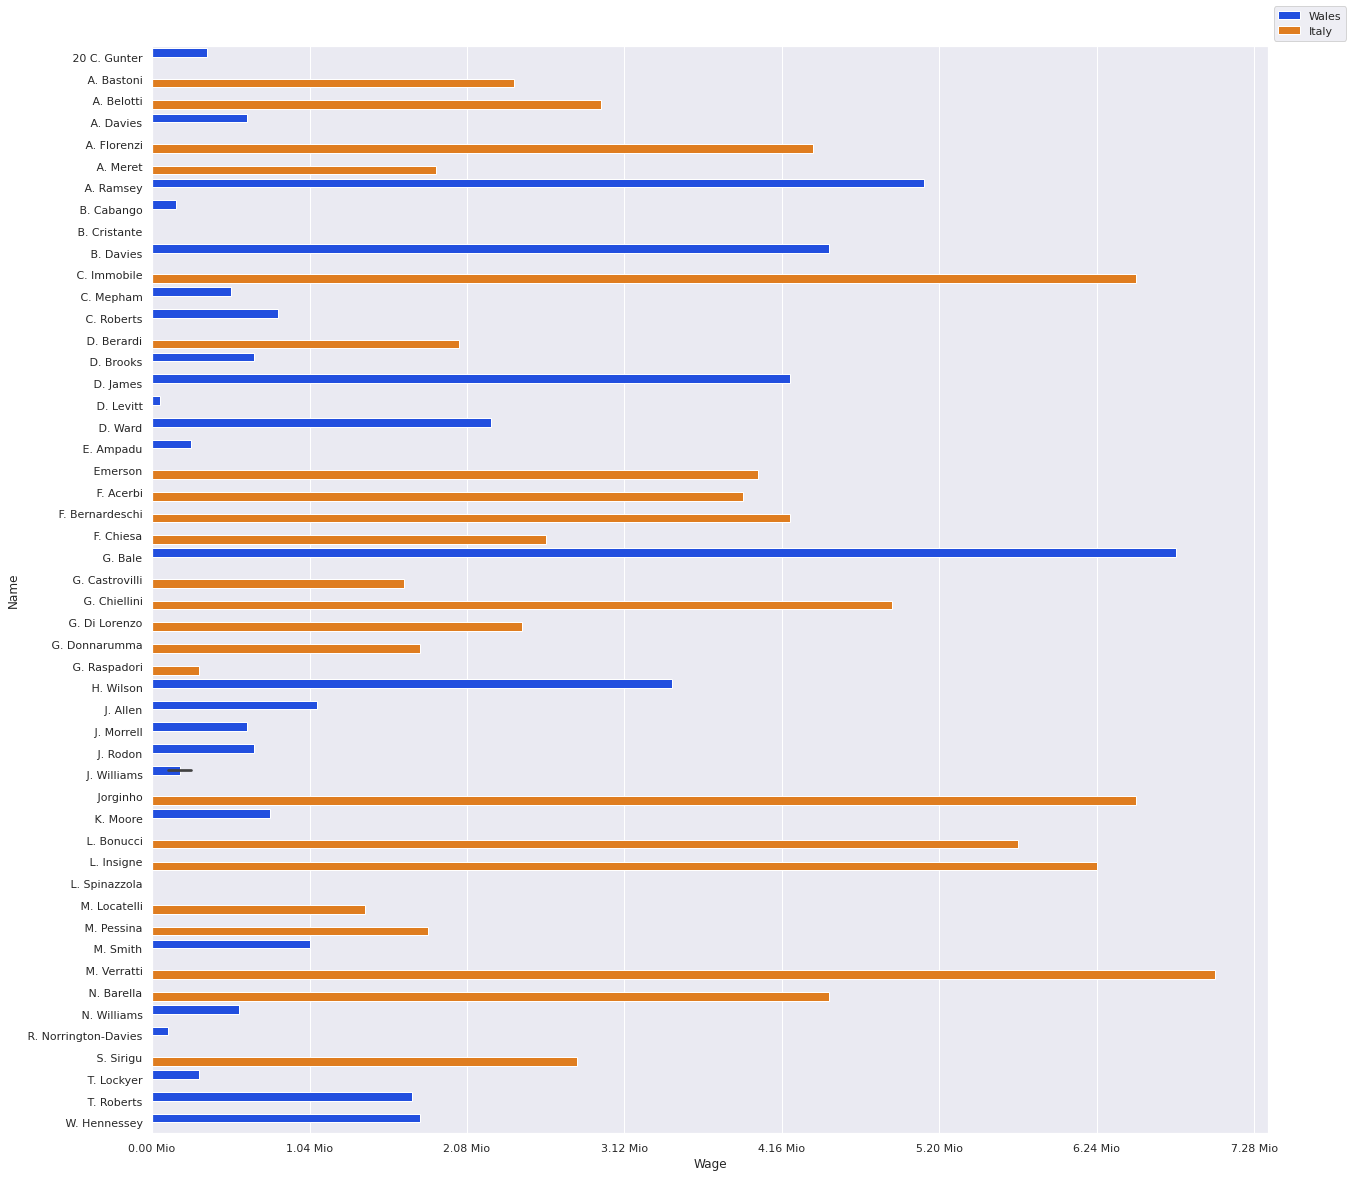

In [30]:
sns.set(style="darkgrid")    
sns.set(rc={'figure.figsize':(20,20)}) 
palette = sns.color_palette("bright", 4)
g = sns.barplot(x="Wage", y = "Name", hue="Nationality", data=our_players, palette= palette, orient="h")
g.legend(bbox_to_anchor=(1, 1), ncol=1)
xlabels = ['{:,.2f}'.format(x*52) + ' Mio' for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)
plt.savefig("player_wages.png")
plt.show()

In [31]:
our_players.to_parquet("ourplayer.pq", index = False)